Pada tugas ini, akan dilakukan klasifikasi gambar bunga dengan Convolutional Neural Network (CNN). Terdapat tiga kelas bunga yaitu daisy, dandelion, dan sunflower, dan terdapat 100 gambar untuk setiap kelas dengan ukuran 320x240 pixels.

# Functions

Pertama, akan didefinisikan terlebih dahulu fungsi-fungsi yang akan digunakan.

In [14]:
# import library yang digunakan
import os
import cv2
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

### Fungsi load dataset

In [3]:
def load(path: str, dim: tuple) -> list:
  """
  # Load data (array of image) dari link external (google drive).
  ---

  parameter:
    path : string, path untuk menuju image
    dim  : tuple of int, ukuran gambar yang diinginkan
  
  return: array of images yang memiliki ukuran pasti
  """

  if type(path) != str:
    raise TypeError("parameter pertama harus dalam bentuk string.")
  if type(dim) != tuple or len(dim) == 0:
    raise TypeError("parameter kedua harus mempunyai nilai tuple yang berisi int.")
  if type(dim[0]) != int or len(dim) != 2:
    raise TypeError("isi dalam parameter pertama harus dalam bentuk int dengan length 2.")

  images = []
  files = os.listdir(path)
  for i in range(len(files)):
    img = cv2.imread(path + "/" + files[i])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    images.append(img)
  return images

### Fungsi visualisasi dataset

In [4]:
def visualize_images(dataset, y, sd):
  """
  # Visualisasi gambar sampel dataset secara random
  ---

  parameter:
    dataset : list of graysacle images
    y       : kelas dataset
    sd      : random seed
    
  """
  plt.gray()
  fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 12))
  plt.suptitle('Visualisasi Sampel Dataset dan Kelasnya',fontsize=25)
  rand.seed(sd)   
  
  index = [rand.randint(0, len(dataset)) for x in range(9)]
  dt = np.array(dataset)
  dt = dt[index]
  target = np.array(y)
  target = target[index]
  
  for img, t, ax in zip(dt, target, axes.ravel()):
    ax.imshow(img)
    ax.set_xlabel(t, fontsize=18)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

In [20]:
def visualize_histogram(image, multiple=False):
  """
  # Generate Image Histogram dari gambar.
  ---
  Apabila terdapat banyak gambar, akan dibuat Image baru yang merupakan rata-
  rata dari gambar yang diberikan.

  parameter:
    image     : image(s) yang akan dibuat histogramnya.
    multiple  : True apabila image lebih dari satu.
    
  """
  if multiple:
    image = np.mean(np.array([arr for arr in image]), axis=0)
  
  cv2_imshow(image)
  
  intensitas_pixel=[]
  for row in range(image.shape[0]):
    for column in range(image.shape[1]):
      intensitas_pixel.append(image[row][column])

  plt.figure(figsize=(10,5))
  plt.hist(intensitas_pixel, bins=256) 
  plt.title("Image Histogram", fontsize=20)
  plt.xlabel("Intensitasi Pixel")
  plt.ylabel("Frekuensi")
  plt.xticks(np.arange(0, 255, 10)) 
  plt.show()

### Fungsi konversi gambar ke format grayscale

In [6]:
def convert_to_grayscale(images: list) -> list:
  """
  # Konversi gambar ke format grayscale.
  ---

  parameter:
    images : list image

  return: list images dalam format graysacle
  """

  if type(images) != list:
    raise TypeError("parameter pertama harus dalam bentuk list of images.")
  if not len(images):
    raise ValueError("list harus berisi.")
  if type(images[0]) != np.ndarray:
    raise TypeError("parameter pertama harus dalam bentuk numpy array.")

  new_images = []
  for image in images:
    new_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
  return new_images

### Fungsi flatten

In [7]:
def flatten(images: list) -> list:
  """
  # Mengubah image dari 2 dimensi menjadi 1 dimensi.
  ---

  parameter:
    imgs : list images

  return: list terdiri dari array 1 dimensi (image yang telah di-flattened)
  """

  if type(images) != list:
    raise TypeError("parameter pertama harus dalam bentuk array of images.")
  if not len(images):
    raise ValueError("array harus berisi.")
  if type(images[0]) != np.ndarray:
    raise TypeError("parameter pertama harus dalam bentuk numpy array.")

  flatten = []
  for i in range(len(images)):
    flat = list(np.concatenate(images[i]).flat)
    flatten.append(flat)
  return flatten

### Fungsi konversi representasi ke one-hot

In [8]:
def to_categorical(y: list) -> np.ndarray:
  """
  # Mengubah representasi kelas menjadi one-hot
  ---

  parameter:
    y : list of int

  return: array of int
  """

  if type(y) != list or not len(y):
    raise TypeError("y harus dalam bentuk array yang berisi.")
  if type(y[0]) != int:
    raise TypeError("isi array harus dalam bentuk int.")

  label = []
  num_class = max(y)+1
  for data in y:
    temp = [0.] * num_class
    temp[data] = 1.
    label.append(temp)
    
  return np.array(label, dtype= 'float32')

### Fungsi split dataset (balanced)

In [9]:
def split_balance(data, ratio, target, shuffle=False, seed=42):
  """
  # Split dataset berdasarkan rasio secara balanced sesuai kelasnya.
  ---
  data dan target harus telah berurut sesuai kelas.

  parameter:
    data   : list
    ratio  : float
    target : list

  return: (data_train, data_test, target_train, target_test)
    data_train   : numpy array
    data_test    : numpy array
    target_train : numpy array
    target_test  : numpy array
  """

  if type(data) != list:
    raise TypeError("data harus dalam bentuk array of object.")
  if type(ratio) != float:
    raise TypeError("ratio harus dalam bentuk float.")
  if type(target) != list:
    raise TypeError("target harus dalam bentuk array of int.")
    
  targets = {}
  for i in target:
    if i not in targets:
      targets[i] = 0
    targets[i] += 1

  data_train, data_test, target_train, target_test = [], [], [], []
  prev_length = 0
  for i in targets:
    next_length  = int(ratio * targets[i])
    data_train += data[prev_length:prev_length+next_length]
    data_test  += data[prev_length+next_length:prev_length+targets[i]]
    target_train += [i]*next_length
    target_test  += [i]*(targets[i]-next_length)
    prev_length += targets[i]

  data_train = np.array(data_train)
  data_train = (data_train/255).astype('float32')
  target_train = to_categorical(target_train)
  data_test =  np.array(data_test)
  data_test = (data_test/255).astype('float32')
  target_test = to_categorical(target_test)

  if shuffle:
    data_train_daisy = data_train[:80]
    data_train_dandelion = data_train[80:160]
    data_train_sunflower = data_train[160:]
    data_train = []

    for i in range(len(data_train_daisy)):
      data_train.append(data_train_daisy[i])
      data_train.append(data_train_dandelion[i])
      data_train.append(data_train_sunflower[i])
    
    target_train = [0, 1, 2] * 80
    target_train = to_categorical(target_train)
    data_train = np.array(data_train)
  
  return data_train, data_test, target_train, target_test

# Main

Pertama, data dalam .rar diekstrak

In [10]:
!unrar x "/content/drive/MyDrive/SEMESTER 6/Machine Learning/flowers100.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/SEMESTER 6/Machine Learning/flowers100.rar

Creating    flowers100                                                OK
Creating    flowers100/daisy                                          OK
Extracting  flowers100/daisy/100080576_f52e8ee070_n.jpg                    0%  OK 
Extracting  flowers100/daisy/102841525_bd6628ae3c.jpg                      0%  OK 
Extracting  flowers100/daisy/10437929963_bc13eebe0c.jpg                    1%  OK 
Extracting  flowers100/daisy/10555815624_dc211569b0.jpg                    2%  OK 
Extracting  flowers100/daisy/105806915_a9c13e2106_n.jpg                    2%  OK 
Extracting  flowers100/daisy/1150395827_6f94a5c6e4_n.jpg                   2%  OK 
Extracting  flowers100/daisy/1392131677_116ec04751.jpg                     2%  OK 
Extracting  flowers100/daisy/13977181862_f8237b6b52.jpg   

Lalu ditentukan dimensi gambar.

In [11]:
dim = (320, 240)

Gambar-gambar di-load sesuai dimensi dan diubah ke format grayscale. Setiap gambar di ketiga kelas digabungkan menjadi satu dalam variabel dataset, dan dibuat variabel target yang berisi kelas-kelas gambar.

In [12]:
daisy = load('./flowers100/daisy', dim)
daisy_preprocessed = convert_to_grayscale(daisy)

dandelion = load('./flowers100/dandelion', dim)
dandelion_preprocessed = convert_to_grayscale(dandelion)

sunflower = load('./flowers100/sunflower', dim)
sunflower_preprocessed = convert_to_grayscale(sunflower)

dataset = daisy_preprocessed + dandelion_preprocessed + sunflower_preprocessed
target = [0 for i in range(100)]+[1 for i in range(100)]+[2 for i in range(100)]

Selanjutnya akan dilihat sampel gambar-gambar pada dataset:

<Figure size 432x288 with 0 Axes>

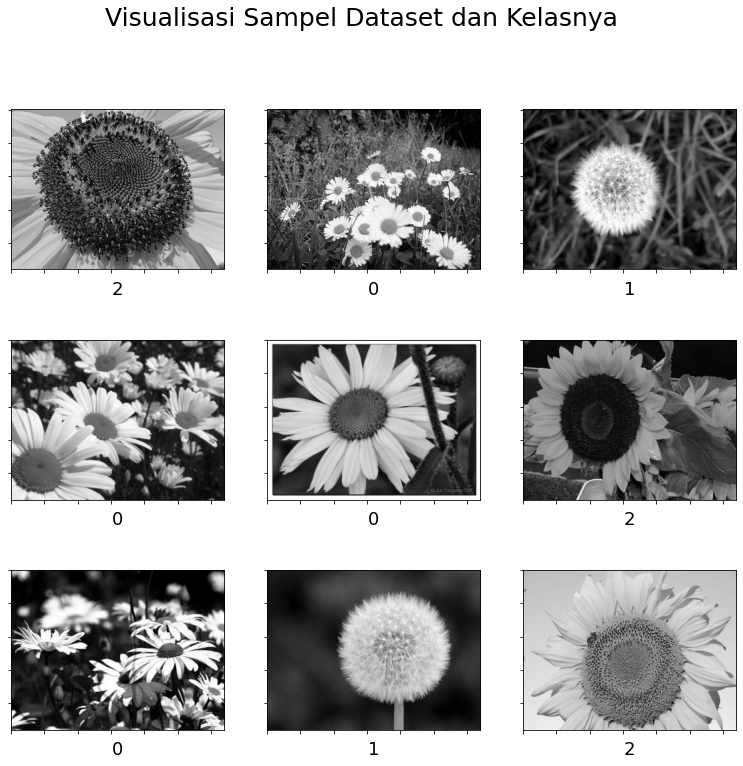

In [15]:
visualize_images(dataset, target, sd=88)

Berikut adalah visualisasi Image Histogram untuk salah satu daisy:

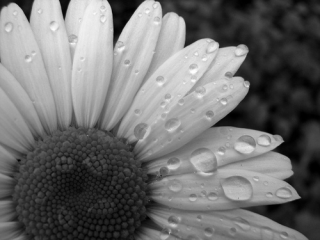

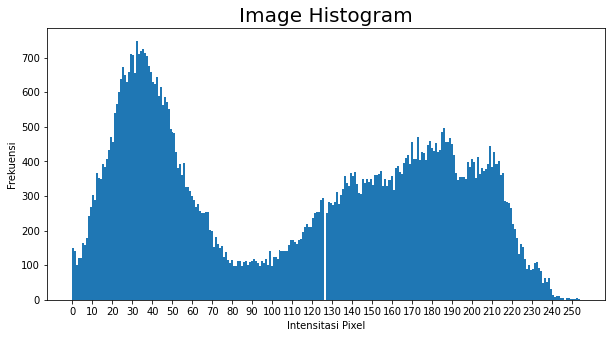

In [21]:
visualize_histogram(daisy_preprocessed[1])

Berikut adalah visualisasi image histogram untuk rata-rata gambar pada kelas daisy, dandelion, dan sunflower:

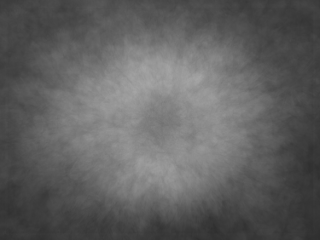

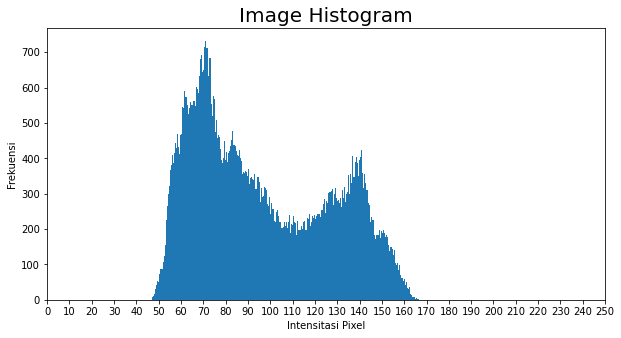

In [22]:
#daisy
visualize_histogram(daisy_preprocessed, multiple=True)

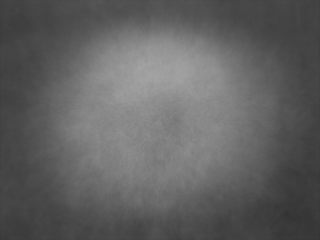

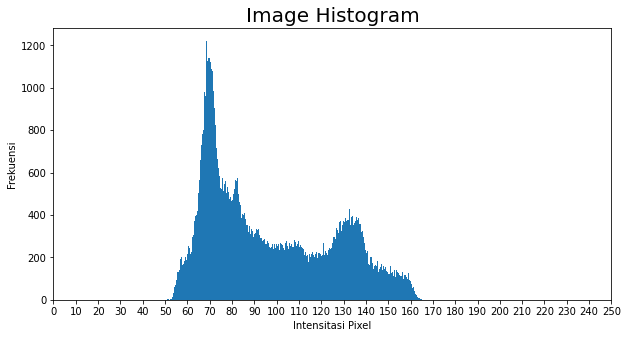

In [23]:
#dandelion
visualize_histogram(dandelion_preprocessed, multiple=True)

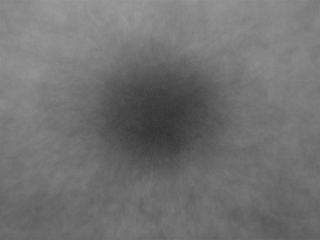

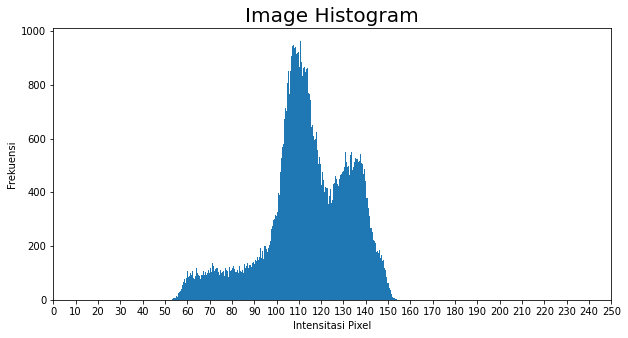

In [24]:
#sunflower
visualize_histogram(sunflower_preprocessed, multiple=True)

dataset dipecah menjadi data latih (80%) dan data uji (20%), dan di-reshape agar dapat menjadi input CNN.

In [25]:
data_train, data_test, target_train, target_test = split_balance(dataset, 0.8, 
                                                                 target, shuffle=True, seed=88)

In [26]:
data_train = data_train.reshape((data_train.shape[0], data_train.shape[1], data_train.shape[2], 1))
data_test = data_test.reshape((data_test.shape[0], data_test.shape[1], data_test.shape[2], 1))

Input shape untuk CNN adalah ukuran dari suatu data gambar

In [27]:
input_shape = data_train.shape[1:]
print(input_shape)

(240, 320, 1)


## Models learning rate 0.1

### Model 1

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(data_train, target_train, epochs=50, validation_data=(data_test, target_test))

Epoch 1/50
8/8 [==============================] - 5s 131ms/step - loss: 1.3089 - accuracy: 0.3873 - val_loss: 1.0959 - val_accuracy: 0.5500
Epoch 2/50
8/8 [==============================] - 0s 59ms/step - loss: 1.0920 - accuracy: 0.5101 - val_loss: 1.0808 - val_accuracy: 0.5333
Epoch 3/50
8/8 [==============================] - 0s 58ms/step - loss: 1.1345 - accuracy: 0.4934 - val_loss: 1.1022 - val_accuracy: 0.3333
Epoch 4/50
8/8 [==============================] - 0s 57ms/step - loss: 1.1049 - accuracy: 0.3567 - val_loss: 6.4148 - val_accuracy: 0.3333
Epoch 5/50
8/8 [==============================] - 0s 58ms/step - loss: 3.0176 - accuracy: 0.4532 - val_loss: 1.0951 - val_accuracy: 0.4000
Epoch 6/50
8/8 [==============================] - 0s 57ms/step - loss: 1.0811 - accuracy: 0.3992 - val_loss: 0.9921 - val_accuracy: 0.5500
Epoch 7/50
8/8 [==============================] - 0s 56ms/step - loss: 0.9765 - accuracy: 0.5330 - val_loss: 1.1033 - val_accuracy: 0.3333
Epoch 8/50
8/8 [==========

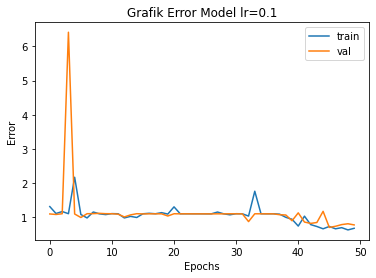

In [ ]:
plt.title('Grafik Error Model lr=0.1')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

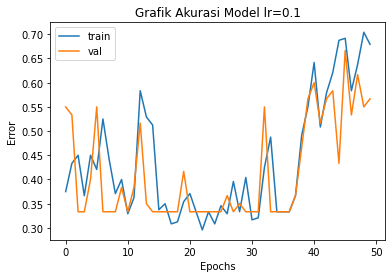

In [ ]:
plt.title('Grafik Akurasi Model lr=0.1')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

### Model 2

In [ ]:
model = Sequential()
model.add(Conv2D(128, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(data_train, target_train, epochs=50, validation_data=(data_test, target_test))

Epoch 1/50
8/8 [==============================] - 1s 116ms/step - loss: 1.5136 - accuracy: 0.4002 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 2/50
8/8 [==============================] - 1s 96ms/step - loss: 1.0961 - accuracy: 0.3638 - val_loss: 1.0941 - val_accuracy: 0.3500
Epoch 3/50
8/8 [==============================] - 1s 97ms/step - loss: 1.0370 - accuracy: 0.4790 - val_loss: 0.9838 - val_accuracy: 0.5167
Epoch 4/50
8/8 [==============================] - 1s 95ms/step - loss: 1.2469 - accuracy: 0.4091 - val_loss: 0.9731 - val_accuracy: 0.5000
Epoch 5/50
8/8 [==============================] - 1s 102ms/step - loss: 1.5325 - accuracy: 0.4374 - val_loss: 1.0983 - val_accuracy: 0.3333
Epoch 6/50
8/8 [==============================] - 1s 101ms/step - loss: 1.0792 - accuracy: 0.4298 - val_loss: 1.1022 - val_accuracy: 0.3500
Epoch 7/50
8/8 [==============================] - 1s 100ms/step - loss: 1.1030 - accuracy: 0.3303 - val_loss: 1.0419 - val_accuracy: 0.4000
Epoch 8/50
8/8 [=======

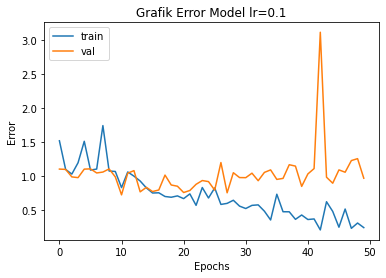

In [ ]:
plt.title('Grafik Error Model lr=0.1')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

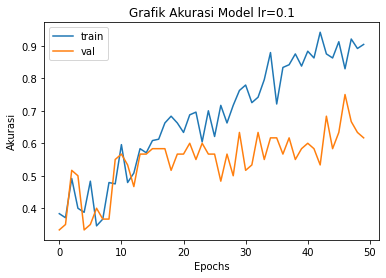

In [ ]:
plt.title('Grafik Akurasi Model lr=0.1')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

### Model 3

In [ ]:
model = Sequential()
model.add(Conv2D(256, (5,5), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((4, 4)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(data_train, target_train, epochs=50, validation_data=(data_test, target_test))

Epoch 1/50
8/8 [==============================] - 1s 137ms/step - loss: 2.0888 - accuracy: 0.3067 - val_loss: 1.0927 - val_accuracy: 0.3667
Epoch 2/50
8/8 [==============================] - 1s 118ms/step - loss: 1.0752 - accuracy: 0.5008 - val_loss: 1.1333 - val_accuracy: 0.3833
Epoch 3/50
8/8 [==============================] - 1s 119ms/step - loss: 1.0424 - accuracy: 0.5508 - val_loss: 2.4092 - val_accuracy: 0.3333
Epoch 4/50
8/8 [==============================] - 1s 120ms/step - loss: 1.5152 - accuracy: 0.4981 - val_loss: 0.9814 - val_accuracy: 0.5333
Epoch 5/50
8/8 [==============================] - 1s 118ms/step - loss: 0.9336 - accuracy: 0.5770 - val_loss: 1.0844 - val_accuracy: 0.4667
Epoch 6/50
8/8 [==============================] - 1s 118ms/step - loss: 0.7803 - accuracy: 0.6397 - val_loss: 0.9474 - val_accuracy: 0.5500
Epoch 7/50
8/8 [==============================] - 1s 119ms/step - loss: 0.8000 - accuracy: 0.6771 - val_loss: 0.7480 - val_accuracy: 0.6333
Epoch 8/50
8/8 [====

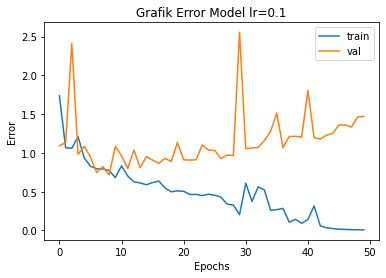

In [ ]:
plt.title('Grafik Error Model lr=0.1')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

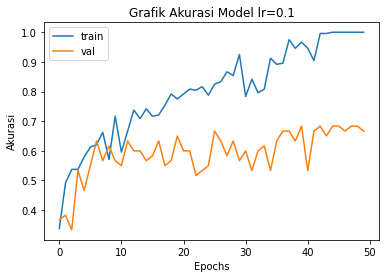

In [ ]:
plt.title('Grafik Akurasi Model lr=0.1')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

### Model 4

## Models learning rate 0.8

### Model 1

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.8)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(data_train, target_train, epochs=50, validation_data=(data_test, target_test))

Epoch 1/50
8/8 [==============================] - 5s 137ms/step - loss: 4474.4656 - accuracy: 0.3507 - val_loss: 1.1314 - val_accuracy: 0.3333
Epoch 2/50
8/8 [==============================] - 0s 58ms/step - loss: 1.1224 - accuracy: 0.3066 - val_loss: 1.1034 - val_accuracy: 0.3333
Epoch 3/50
8/8 [==============================] - 0s 58ms/step - loss: 1.1037 - accuracy: 0.2903 - val_loss: 1.1046 - val_accuracy: 0.3333
Epoch 4/50
8/8 [==============================] - 0s 58ms/step - loss: 1.1152 - accuracy: 0.2970 - val_loss: 1.1015 - val_accuracy: 0.3333
Epoch 5/50
8/8 [==============================] - 0s 58ms/step - loss: 1.1053 - accuracy: 0.3301 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 6/50
8/8 [==============================] - 0s 57ms/step - loss: 1.1007 - accuracy: 0.3379 - val_loss: 1.1024 - val_accuracy: 0.3333
Epoch 7/50
8/8 [==============================] - 0s 57ms/step - loss: 1.1076 - accuracy: 0.3401 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 8/50
8/8 [=======

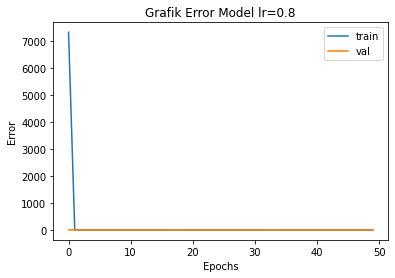

In [ ]:
plt.title('Grafik Error Model lr=0.8')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

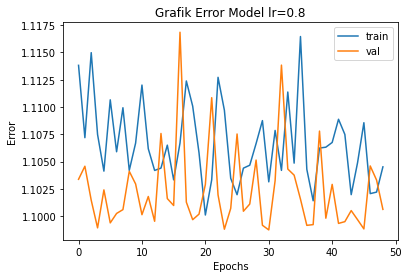

In [ ]:
plt.title('Grafik Error Model lr=0.8')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='val')
plt.legend()
plt.show()

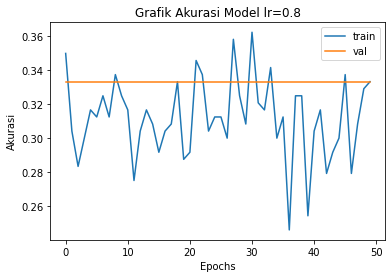

In [ ]:
plt.title('Grafik Akurasi Model lr=0.8')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

### Model 2

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.8)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(data_train, target_train, epochs=50, validation_data=(data_test, target_test))

Epoch 1/50
8/8 [==============================] - 1s 76ms/step - loss: 505.8010 - accuracy: 0.3458 - val_loss: 1.1059 - val_accuracy: 0.3333
Epoch 2/50
8/8 [==============================] - 0s 54ms/step - loss: 1.1034 - accuracy: 0.3510 - val_loss: 1.1016 - val_accuracy: 0.3333
Epoch 3/50
8/8 [==============================] - 0s 54ms/step - loss: 1.1031 - accuracy: 0.3598 - val_loss: 1.1053 - val_accuracy: 0.3333
Epoch 4/50
8/8 [==============================] - 0s 54ms/step - loss: 2.2846 - accuracy: 0.2942 - val_loss: 1.1083 - val_accuracy: 0.3333
Epoch 5/50
8/8 [==============================] - 0s 55ms/step - loss: 1.1094 - accuracy: 0.2906 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 6/50
8/8 [==============================] - 0s 53ms/step - loss: 1.1004 - accuracy: 0.3379 - val_loss: 1.1037 - val_accuracy: 0.3333
Epoch 7/50
8/8 [==============================] - 0s 54ms/step - loss: 1.1081 - accuracy: 0.3401 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 8/50
8/8 [=========

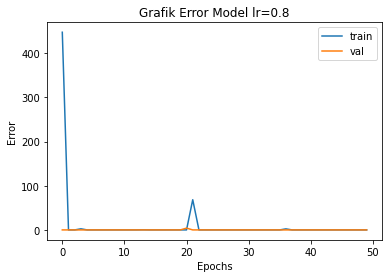

In [ ]:
plt.title('Grafik Error Model lr=0.8')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

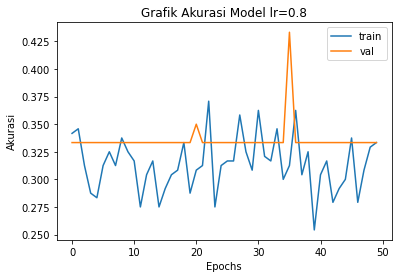

In [ ]:
plt.title('Grafik Akurasi Model lr=0.8')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

### Model 3

In [ ]:
model = Sequential()
model.add(Conv2D(128, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.8)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(data_train, target_train, epochs=50, validation_data=(data_test, target_test))

Epoch 1/50
8/8 [==============================] - 1s 115ms/step - loss: 2071.4646 - accuracy: 0.3780 - val_loss: 2.3655 - val_accuracy: 0.3333
Epoch 2/50
8/8 [==============================] - 1s 97ms/step - loss: 1.5079 - accuracy: 0.3097 - val_loss: 1.1016 - val_accuracy: 0.3333
Epoch 3/50
8/8 [==============================] - 1s 95ms/step - loss: 1.1117 - accuracy: 0.3225 - val_loss: 1.1236 - val_accuracy: 0.3333
Epoch 4/50
8/8 [==============================] - 1s 96ms/step - loss: 1.1320 - accuracy: 0.2640 - val_loss: 1.1017 - val_accuracy: 0.3333
Epoch 5/50
8/8 [==============================] - 1s 94ms/step - loss: 1.1053 - accuracy: 0.3301 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 6/50
8/8 [==============================] - 1s 95ms/step - loss: 1.1007 - accuracy: 0.3379 - val_loss: 1.1024 - val_accuracy: 0.3333
Epoch 7/50
8/8 [==============================] - 1s 101ms/step - loss: 1.1074 - accuracy: 0.3401 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 8/50
8/8 [======

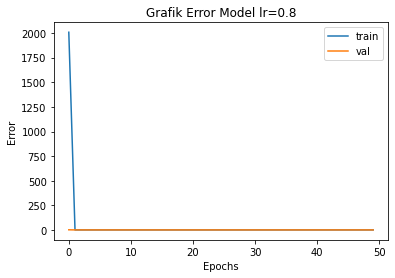

In [ ]:
plt.title('Grafik Error Model lr=0.8')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

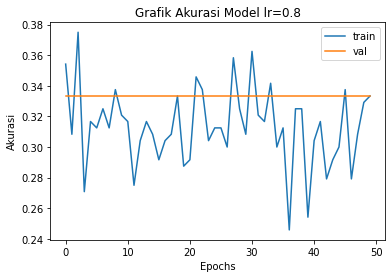

In [ ]:
plt.title('Grafik Akurasi Model lr=0.8')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

## Additional Model

In [ ]:
model = Sequential()
model.add(Conv2D(128, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(data_train, target_train, epochs=50, validation_data=(data_test, target_test))

Epoch 1/50
8/8 [==============================] - 2s 155ms/step - loss: 41.0268 - accuracy: 0.4156 - val_loss: 8.2956 - val_accuracy: 0.4333
Epoch 2/50
8/8 [==============================] - 1s 132ms/step - loss: 10.4115 - accuracy: 0.4396 - val_loss: 2.7682 - val_accuracy: 0.5833
Epoch 3/50
8/8 [==============================] - 1s 133ms/step - loss: 1.8553 - accuracy: 0.6708 - val_loss: 1.2016 - val_accuracy: 0.5333
Epoch 4/50
8/8 [==============================] - 1s 130ms/step - loss: 0.5171 - accuracy: 0.7470 - val_loss: 0.7338 - val_accuracy: 0.7667
Epoch 5/50
8/8 [==============================] - 1s 130ms/step - loss: 0.3310 - accuracy: 0.9564 - val_loss: 0.5494 - val_accuracy: 0.8000
Epoch 6/50
8/8 [==============================] - 1s 130ms/step - loss: 0.1640 - accuracy: 0.9745 - val_loss: 0.5822 - val_accuracy: 0.8000
Epoch 7/50
8/8 [==============================] - 1s 129ms/step - loss: 0.0808 - accuracy: 0.9806 - val_loss: 0.5792 - val_accuracy: 0.7833
Epoch 8/50
8/8 [==

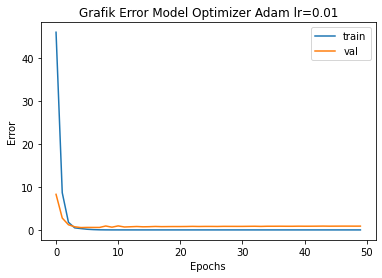

In [ ]:
plt.title('Grafik Error Model Optimizer Adam lr=0.01')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

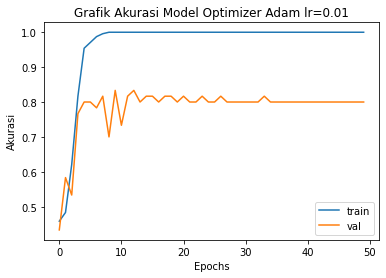

In [ ]:
plt.title('Grafik Akurasi Model Optimizer Adam lr=0.01')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()